## 1. Setup & Import Libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import warnings

# Scikit-learn
from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error, 
    r2_score,
    mean_absolute_percentage_error
)

# Plotting settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore')

# Paths
PROCESSED_DATA_DIR = Path('../data/processed')
MODELS_DIR = Path('../models')
REPORTS_DIR = Path('../reports')
REPORTS_DIR.mkdir(exist_ok=True)

print("✅ Setup complete!")


✅ Setup complete!


## 2. Load Data & Model

In [2]:
# Load processed data
train_df = pd.read_parquet(PROCESSED_DATA_DIR / 'train.parquet')
val_df = pd.read_parquet(PROCESSED_DATA_DIR / 'val.parquet')
test_df = pd.read_parquet(PROCESSED_DATA_DIR / 'test.parquet')

# Load feature config
feature_config = joblib.load(PROCESSED_DATA_DIR / 'feature_config.joblib')
ALL_FEATURES = feature_config['all_features']
TARGET = feature_config['target']

print(f"📊 Data loaded:")
print(f"   Train: {train_df.shape}")
print(f"   Val: {val_df.shape}")
print(f"   Test: {test_df.shape}")
print(f"   Features: {len(ALL_FEATURES)}")


📊 Data loaded:
   Train: (11168247, 19)
   Val: (2393196, 19)
   Test: (2393196, 19)
   Features: 18


In [3]:
# Load tuned model
model = joblib.load(MODELS_DIR / 'tuned_model.joblib')
model_metadata = joblib.load(MODELS_DIR / 'tuned_model_metadata.joblib')

MODEL_NAME = model_metadata['model_name']
print(f"🤖 Model loaded: {MODEL_NAME}")
print(f"   Type: {model_metadata['model_type']}")
print(f"   Optuna trials: {model_metadata['optuna_trials']}")


🤖 Model loaded: random_forest
   Type: tuned
   Optuna trials: 30


In [4]:
# Prepare features and target
X_train = train_df[ALL_FEATURES]
y_train = train_df[TARGET]

X_val = val_df[ALL_FEATURES]
y_val = val_df[TARGET]

X_test = test_df[ALL_FEATURES]
y_test = test_df[TARGET]

# Make predictions
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

print("✅ Predictions generated")


✅ Predictions generated


## 3. Overall Metrics

In [6]:
def calculate_metrics(y_true, y_pred):
    """Calculate comprehensive metrics"""
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R²': r2_score(y_true, y_pred),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred) * 100,
        'Median AE': np.median(np.abs(y_true - y_pred)),
        'Max Error': np.max(np.abs(y_true - y_pred)),
        'Std Error': np.std(y_true - y_pred)
    }

# Calculate metrics for all sets
train_metrics = calculate_metrics(y_train, y_train_pred)
val_metrics = calculate_metrics(y_val, y_val_pred)
test_metrics = calculate_metrics(y_test, y_test_pred)

# Create summary table
metrics_df = pd.DataFrame({
    'Train': train_metrics,
    'Validation': val_metrics,
    'Test': test_metrics
}).T

print("📊 Model Performance Summary:")
print("="*70)
metrics_df


📊 Model Performance Summary:


,MAE,RMSE,R²,MAPE,Median AE,Max Error,Std Error
Train,0.978017,3.055069,0.967605,5.515986,0.388499,469.444225,3.055069
Validation,0.999943,3.225690,0.964053,5.568492,0.389797,362.483823,3.225690
Test,1.002602,3.215516,0.964349,5.572485,0.389601,350.108230,3.215512


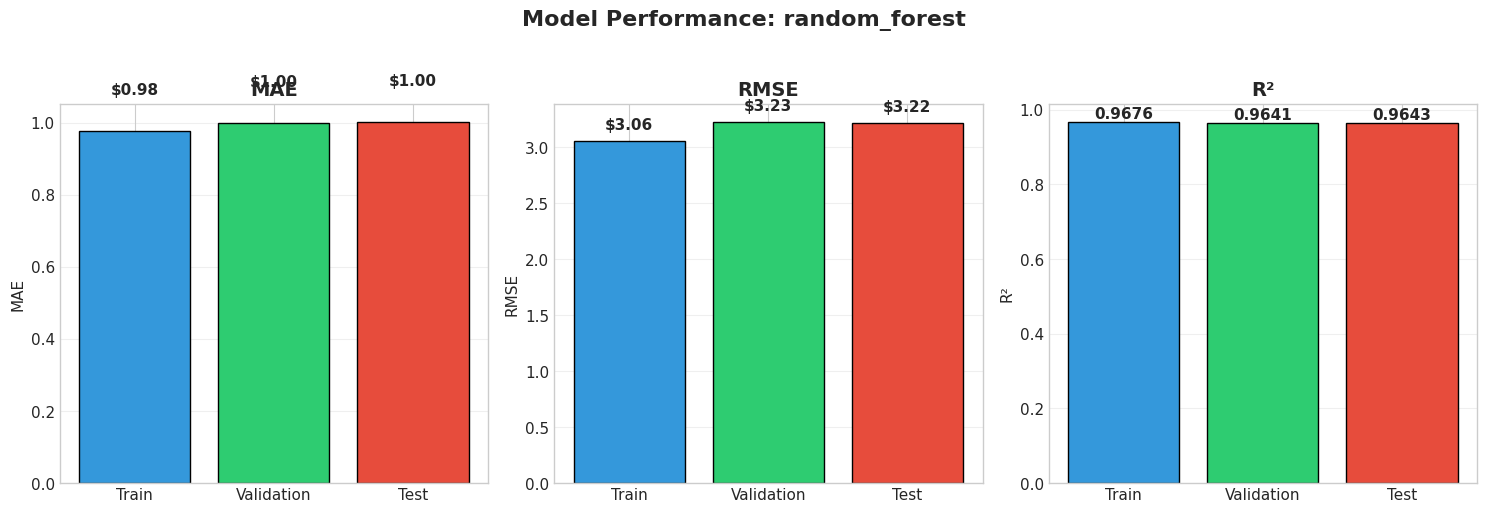

✅ Saved: ../reports/metrics_comparison.png


In [7]:
# Visual metrics comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics_to_plot = ['MAE', 'RMSE', 'R²']
colors = ['#3498db', '#2ecc71', '#e74c3c']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    values = [train_metrics[metric], val_metrics[metric], test_metrics[metric]]
    bars = ax.bar(['Train', 'Validation', 'Test'], values, color=colors, edgecolor='black')
    
    # Add value labels
    for bar, val in zip(bars, values):
        if metric == 'R²':
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                   f'{val:.4f}', ha='center', fontsize=11, fontweight='bold')
        else:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                   f'${val:.2f}', ha='center', fontsize=11, fontweight='bold')
    
    ax.set_title(f'{metric}', fontsize=14, fontweight='bold')
    ax.set_ylabel(metric)
    ax.grid(axis='y', alpha=0.3)

plt.suptitle(f'Model Performance: {MODEL_NAME}', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(REPORTS_DIR / 'metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Saved: {REPORTS_DIR / 'metrics_comparison.png'}")


## 4. Error Analysis

In [8]:
# Calculate errors
test_df_analysis = test_df.copy()
test_df_analysis['predicted'] = y_test_pred
test_df_analysis['error'] = y_test - y_test_pred
test_df_analysis['abs_error'] = np.abs(test_df_analysis['error'])
test_df_analysis['pct_error'] = (test_df_analysis['abs_error'] / y_test) * 100

print("📊 Error Statistics (Test Set):")
print(f"   Mean Error: ${test_df_analysis['error'].mean():.4f}")
print(f"   Std Error:  ${test_df_analysis['error'].std():.4f}")
print(f"   Min Error:  ${test_df_analysis['error'].min():.4f}")
print(f"   Max Error:  ${test_df_analysis['error'].max():.4f}")
print(f"\n   Mean Abs Error: ${test_df_analysis['abs_error'].mean():.4f}")
print(f"   Median Abs Error: ${test_df_analysis['abs_error'].median():.4f}")


📊 Error Statistics (Test Set):
   Mean Error: $0.0049
   Std Error:  $3.2155
   Min Error:  $-286.7372
   Max Error:  $350.1082

   Mean Abs Error: $1.0026
   Median Abs Error: $0.3896


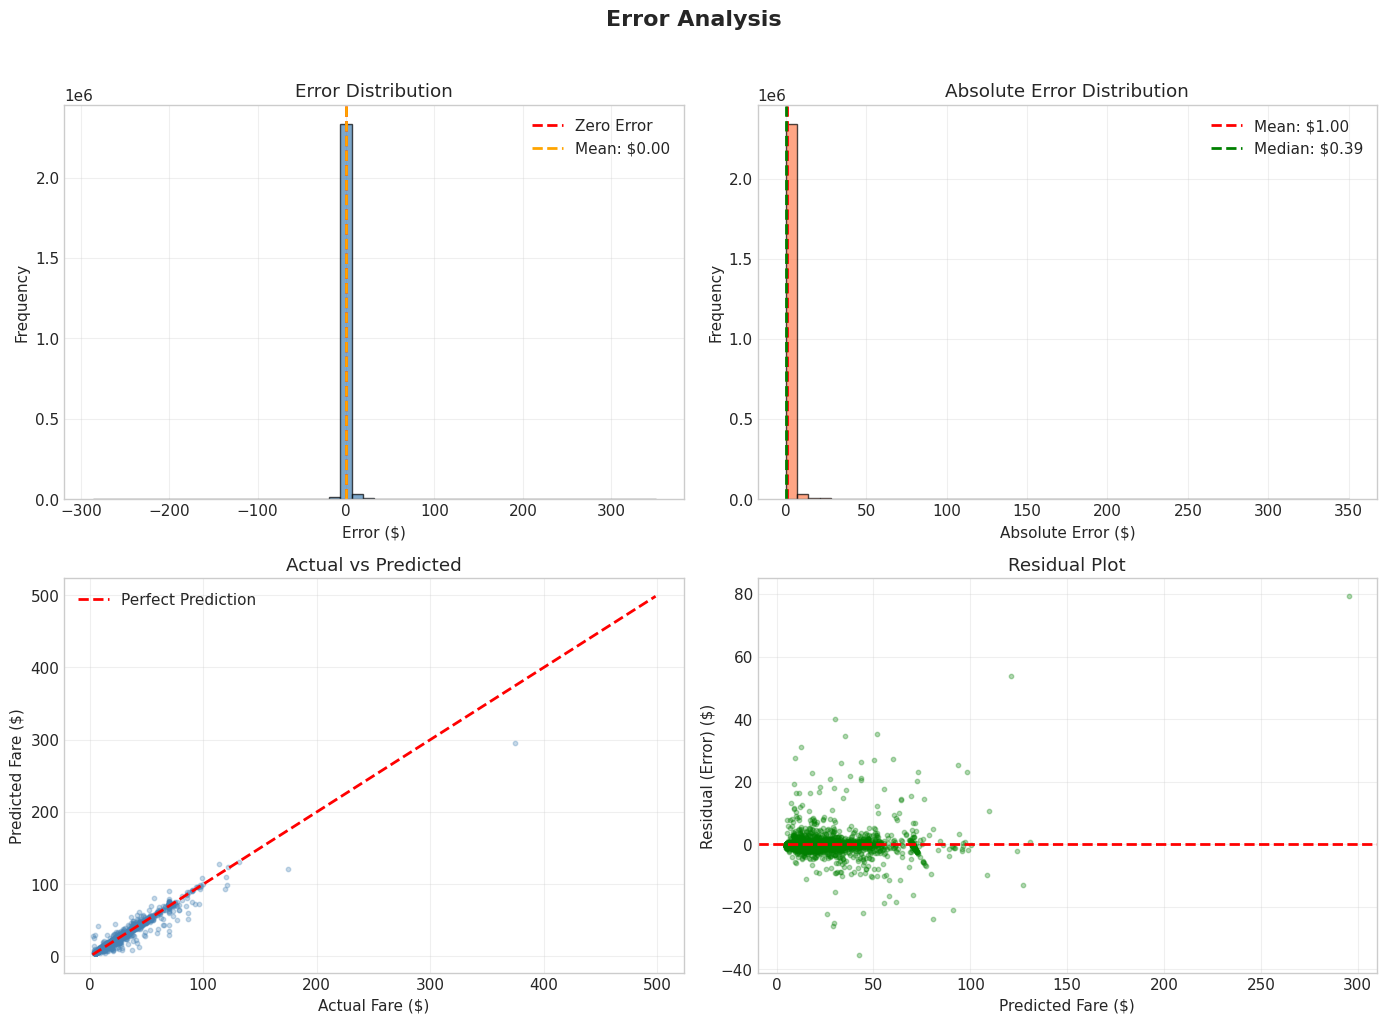

✅ Saved: ../reports/error_analysis.png


In [9]:
# Error distribution visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Error distribution (histogram)
ax1 = axes[0, 0]
ax1.hist(test_df_analysis['error'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax1.axvline(x=test_df_analysis['error'].mean(), color='orange', linestyle='--', linewidth=2, 
            label=f'Mean: ${test_df_analysis["error"].mean():.2f}')
ax1.set_xlabel('Error ($)')
ax1.set_ylabel('Frequency')
ax1.set_title('Error Distribution')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Absolute error distribution
ax2 = axes[0, 1]
ax2.hist(test_df_analysis['abs_error'], bins=50, edgecolor='black', alpha=0.7, color='coral')
ax2.axvline(x=test_df_analysis['abs_error'].mean(), color='red', linestyle='--', linewidth=2,
            label=f'Mean: ${test_df_analysis["abs_error"].mean():.2f}')
ax2.axvline(x=test_df_analysis['abs_error'].median(), color='green', linestyle='--', linewidth=2,
            label=f'Median: ${test_df_analysis["abs_error"].median():.2f}')
ax2.set_xlabel('Absolute Error ($)')
ax2.set_ylabel('Frequency')
ax2.set_title('Absolute Error Distribution')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Actual vs Predicted
ax3 = axes[1, 0]
sample_size = min(5000, len(test_df_analysis))
sample_idx = np.random.choice(len(test_df_analysis), sample_size, replace=False)
ax3.scatter(y_test.iloc[sample_idx], y_test_pred[sample_idx], alpha=0.3, s=10, c='steelblue')
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
ax3.set_xlabel('Actual Fare ($)')
ax3.set_ylabel('Predicted Fare ($)')
ax3.set_title('Actual vs Predicted')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Residual plot
ax4 = axes[1, 1]
ax4.scatter(y_test_pred[sample_idx], test_df_analysis['error'].iloc[sample_idx], alpha=0.3, s=10, c='green')
ax4.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax4.set_xlabel('Predicted Fare ($)')
ax4.set_ylabel('Residual (Error) ($)')
ax4.set_title('Residual Plot')
ax4.grid(alpha=0.3)

plt.suptitle('Error Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(REPORTS_DIR / 'error_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Saved: {REPORTS_DIR / 'error_analysis.png'}")


In [10]:
# Error percentiles
percentiles = [50, 75, 90, 95, 99]
abs_error_percentiles = np.percentile(test_df_analysis['abs_error'], percentiles)

print("📊 Absolute Error Percentiles:")
print("-"*40)
for p, val in zip(percentiles, abs_error_percentiles):
    print(f"   {p}th percentile: ${val:.2f}")

# Error buckets
error_buckets = [
    (0, 1, 'Excellent'),
    (1, 2, 'Good'),
    (2, 5, 'Acceptable'),
    (5, 10, 'Poor'),
    (10, float('inf'), 'Very Poor')
]

print("\n📊 Error Bucket Analysis:")
print("-"*50)
for low, high, label in error_buckets:
    if high == float('inf'):
        mask = test_df_analysis['abs_error'] >= low
        range_str = f"≥ ${low}"
    else:
        mask = (test_df_analysis['abs_error'] >= low) & (test_df_analysis['abs_error'] < high)
        range_str = f"${low} - ${high}"
    
    count = mask.sum()
    pct = (count / len(test_df_analysis)) * 100
    print(f"   {label:12} ({range_str:12}): {count:,} ({pct:.1f}%)")


📊 Absolute Error Percentiles:
----------------------------------------
   50th percentile: $0.39
   75th percentile: $0.80
   90th percentile: $1.83
   95th percentile: $3.46
   99th percentile: $11.61

📊 Error Bucket Analysis:
--------------------------------------------------
   Excellent    ($0 - $1     ): 1,925,330 (80.5%)
   Good         ($1 - $2     ): 250,176 (10.5%)
   Acceptable   ($2 - $5     ): 140,062 (5.9%)
   Poor         ($5 - $10    ): 48,042 (2.0%)
   Very Poor    (≥ $10       ): 29,586 (1.2%)


## 5. Feature Importance

In [11]:
# Get feature importance
if hasattr(model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': ALL_FEATURES,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("📊 Top 15 Most Important Features:")
    print(feature_importance.head(15).to_string(index=False))
else:
    print("⚠️ Model doesn't have feature_importances_ attribute")
    feature_importance = None


📊 Top 15 Most Important Features:
              feature  importance
        trip_distance    0.564220
trip_duration_minutes    0.286632
            has_tolls    0.065442
        avg_speed_mph    0.040529
         DOLocationID    0.027219
         PULocationID    0.010553
             VendorID    0.001936
        same_location    0.000628
             hour_cos    0.000617
      passenger_count    0.000538
          pickup_hour    0.000529
             hour_sin    0.000409
         pickup_month    0.000226
              dow_sin    0.000179
     pickup_dayofweek    0.000172


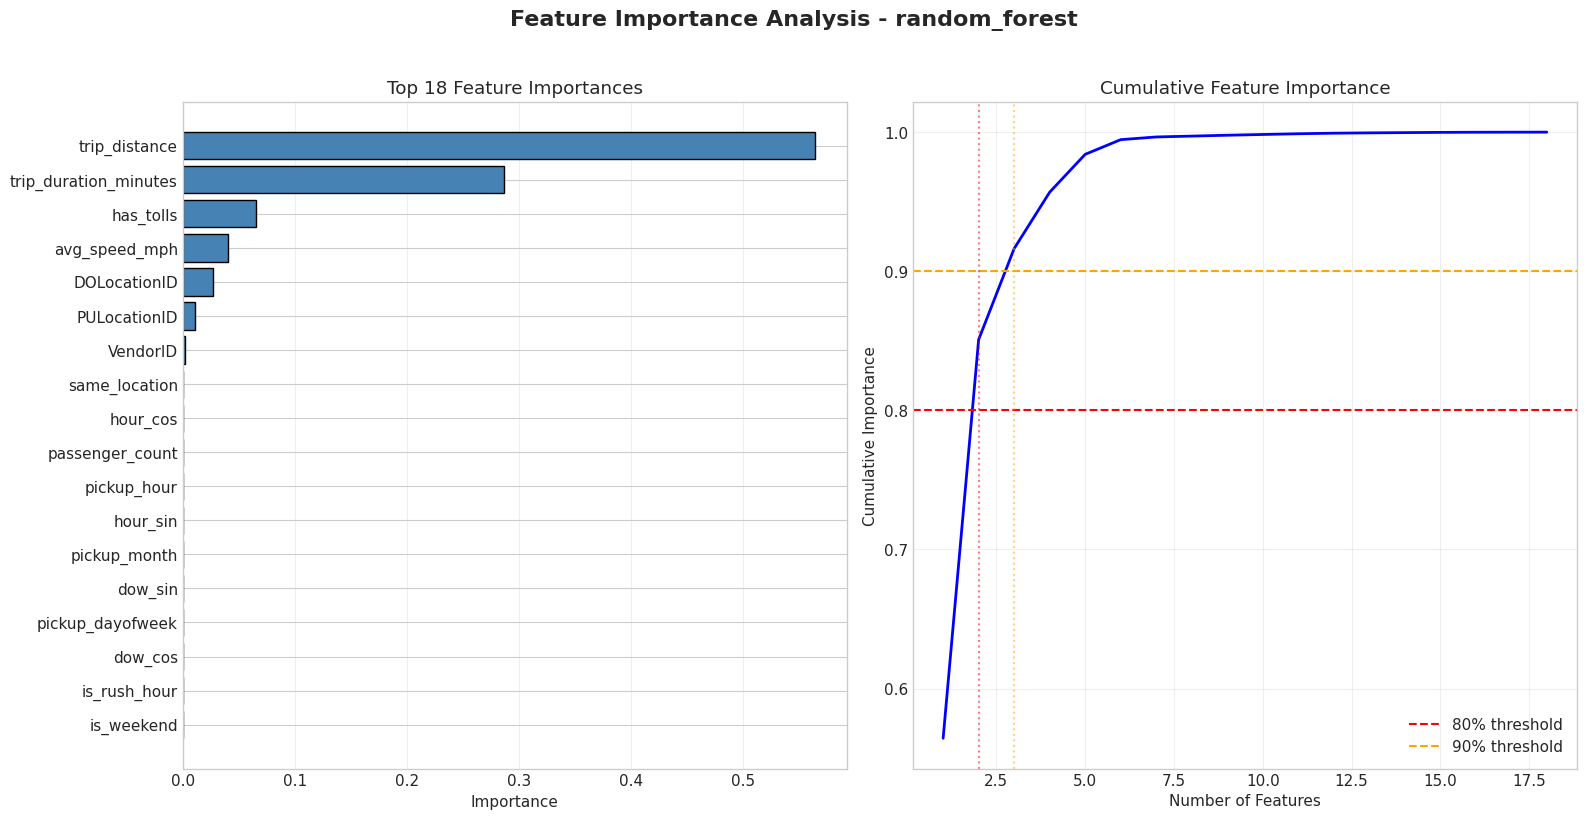


📊 Features needed for 80% importance: 2
📊 Features needed for 90% importance: 3

✅ Saved: ../reports/feature_importance.png


In [12]:
# Feature importance visualization
if feature_importance is not None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Top 20 features
    top_n = min(20, len(feature_importance))
    top_features = feature_importance.head(top_n)
    
    # Bar plot
    ax1 = axes[0]
    bars = ax1.barh(range(top_n), top_features['importance'].values, color='steelblue', edgecolor='black')
    ax1.set_yticks(range(top_n))
    ax1.set_yticklabels(top_features['feature'].values)
    ax1.invert_yaxis()
    ax1.set_xlabel('Importance')
    ax1.set_title(f'Top {top_n} Feature Importances')
    ax1.grid(axis='x', alpha=0.3)
    
    # Cumulative importance
    ax2 = axes[1]
    cumsum = feature_importance['importance'].cumsum()
    ax2.plot(range(1, len(cumsum)+1), cumsum.values, 'b-', linewidth=2)
    ax2.axhline(y=0.8, color='red', linestyle='--', label='80% threshold')
    ax2.axhline(y=0.9, color='orange', linestyle='--', label='90% threshold')
    ax2.set_xlabel('Number of Features')
    ax2.set_ylabel('Cumulative Importance')
    ax2.set_title('Cumulative Feature Importance')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    # Find features needed for 80% and 90%
    n_features_80 = (cumsum < 0.8).sum() + 1
    n_features_90 = (cumsum < 0.9).sum() + 1
    ax2.axvline(x=n_features_80, color='red', linestyle=':', alpha=0.5)
    ax2.axvline(x=n_features_90, color='orange', linestyle=':', alpha=0.5)
    
    plt.suptitle(f'Feature Importance Analysis - {MODEL_NAME}', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(REPORTS_DIR / 'feature_importance.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n📊 Features needed for 80% importance: {n_features_80}")
    print(f"📊 Features needed for 90% importance: {n_features_90}")
    print(f"\n✅ Saved: {REPORTS_DIR / 'feature_importance.png'}")


## 6. Performance by Segments

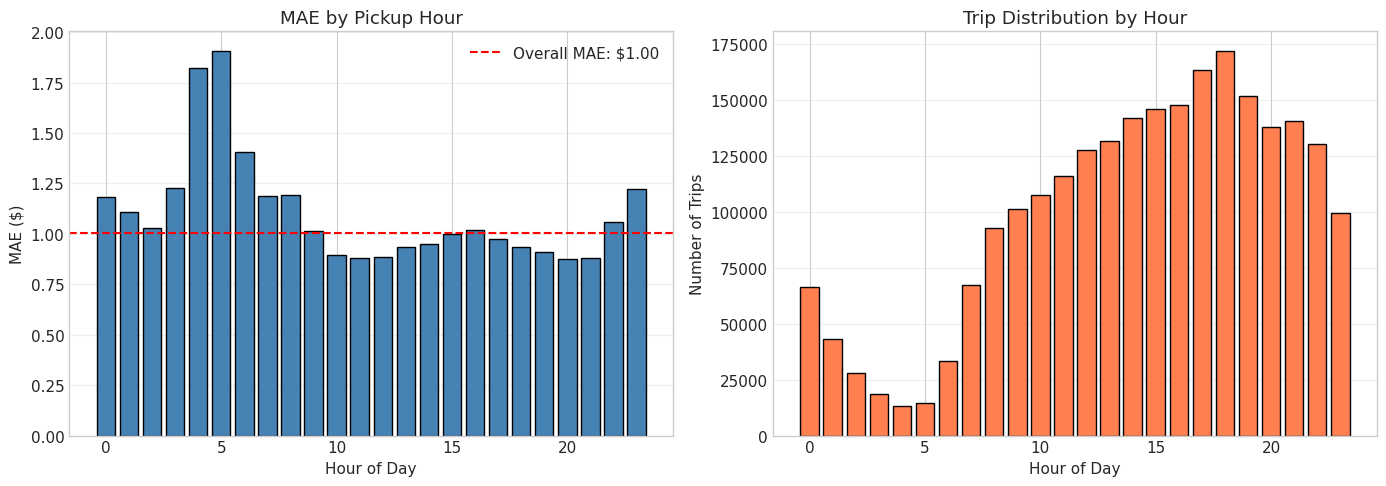

✅ Saved: ../reports/performance_by_hour.png


In [13]:
# Performance by hour
if 'pickup_hour' in test_df_analysis.columns:
    hourly_metrics = test_df_analysis.groupby('pickup_hour').apply(
        lambda x: pd.Series({
            'MAE': mean_absolute_error(x[TARGET], x['predicted']),
            'Count': len(x),
            'Avg_Fare': x[TARGET].mean()
        })
    ).reset_index()
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # MAE by hour
    ax1 = axes[0]
    ax1.bar(hourly_metrics['pickup_hour'], hourly_metrics['MAE'], color='steelblue', edgecolor='black')
    ax1.axhline(y=test_metrics['MAE'], color='red', linestyle='--', label=f'Overall MAE: ${test_metrics["MAE"]:.2f}')
    ax1.set_xlabel('Hour of Day')
    ax1.set_ylabel('MAE ($)')
    ax1.set_title('MAE by Pickup Hour')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Trip count by hour
    ax2 = axes[1]
    ax2.bar(hourly_metrics['pickup_hour'], hourly_metrics['Count'], color='coral', edgecolor='black')
    ax2.set_xlabel('Hour of Day')
    ax2.set_ylabel('Number of Trips')
    ax2.set_title('Trip Distribution by Hour')
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(REPORTS_DIR / 'performance_by_hour.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Saved: {REPORTS_DIR / 'performance_by_hour.png'}")


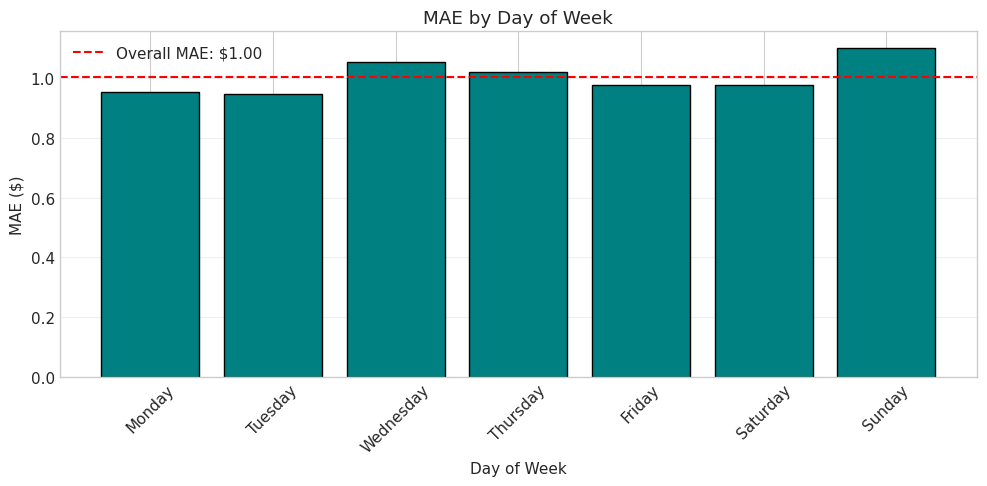

✅ Saved: ../reports/performance_by_day.png


In [14]:
# Performance by day of week
if 'pickup_dayofweek' in test_df_analysis.columns:
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    daily_metrics = test_df_analysis.groupby('pickup_dayofweek').apply(
        lambda x: pd.Series({
            'MAE': mean_absolute_error(x[TARGET], x['predicted']),
            'Count': len(x)
        })
    ).reset_index()
    daily_metrics['day_name'] = daily_metrics['pickup_dayofweek'].map(lambda x: day_names[int(x)])
    
    fig, ax = plt.subplots(figsize=(10, 5))
    bars = ax.bar(daily_metrics['day_name'], daily_metrics['MAE'], color='teal', edgecolor='black')
    ax.axhline(y=test_metrics['MAE'], color='red', linestyle='--', label=f'Overall MAE: ${test_metrics["MAE"]:.2f}')
    ax.set_xlabel('Day of Week')
    ax.set_ylabel('MAE ($)')
    ax.set_title('MAE by Day of Week')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(REPORTS_DIR / 'performance_by_day.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Saved: {REPORTS_DIR / 'performance_by_day.png'}")


In [15]:
# Performance by fare range
fare_bins = [0, 10, 20, 30, 50, 100, float('inf')]
fare_labels = ['$0-10', '$10-20', '$20-30', '$30-50', '$50-100', '$100+']

test_df_analysis['fare_range'] = pd.cut(
    test_df_analysis[TARGET], 
    bins=fare_bins, 
    labels=fare_labels,
    include_lowest=True
)

fare_range_metrics = test_df_analysis.groupby('fare_range', observed=True).apply(
    lambda x: pd.Series({
        'MAE': mean_absolute_error(x[TARGET], x['predicted']),
        'MAPE': mean_absolute_percentage_error(x[TARGET], x['predicted']) * 100,
        'Count': len(x),
        'Pct': len(x) / len(test_df_analysis) * 100
    })
).reset_index()

print("📊 Performance by Fare Range:")
print(fare_range_metrics.to_string(index=False))


📊 Performance by Fare Range:
fare_range       MAE      MAPE    Count       Pct
     $0-10  0.445330  7.086676 760369.0 31.772116
    $10-20  0.658969  4.553897 961479.0 40.175523
    $20-30  1.352438  5.569423 306876.0 12.822853
    $30-50  1.964709  5.201493 212815.0  8.892502
   $50-100  3.161504  4.561577 145425.0  6.076602
     $100+ 21.551830 14.383642   6232.0  0.260405


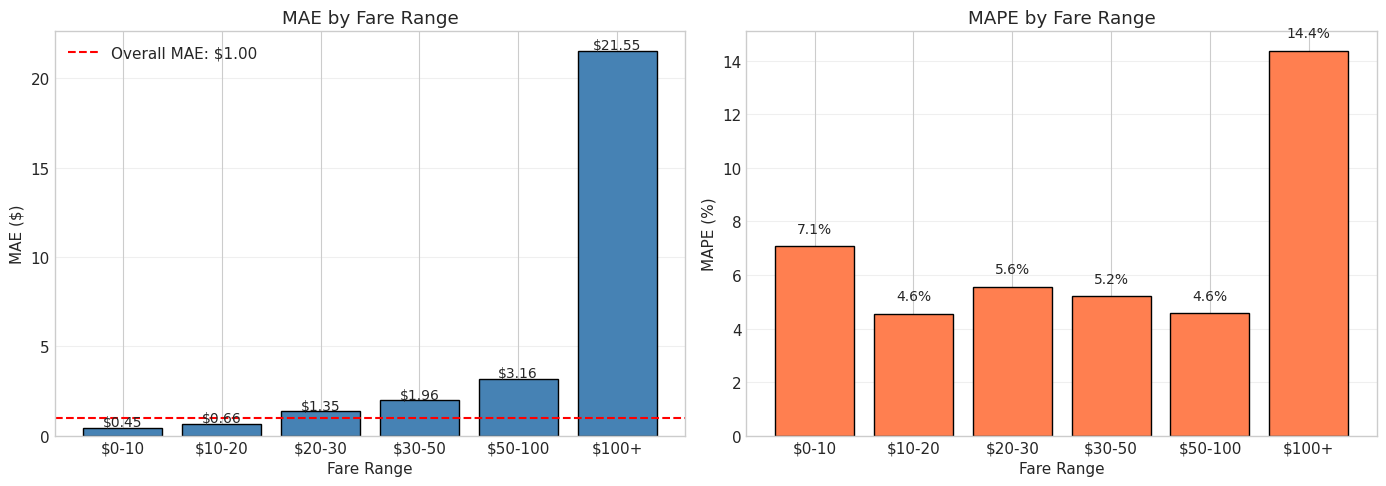

✅ Saved: ../reports/performance_by_fare_range.png


In [16]:
# Visualize performance by fare range
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MAE by fare range
ax1 = axes[0]
bars = ax1.bar(fare_range_metrics['fare_range'].astype(str), fare_range_metrics['MAE'], 
               color='steelblue', edgecolor='black')
ax1.axhline(y=test_metrics['MAE'], color='red', linestyle='--', label=f'Overall MAE: ${test_metrics["MAE"]:.2f}')
ax1.set_xlabel('Fare Range')
ax1.set_ylabel('MAE ($)')
ax1.set_title('MAE by Fare Range')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bar, val in zip(bars, fare_range_metrics['MAE']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
            f'${val:.2f}', ha='center', fontsize=10)

# MAPE by fare range
ax2 = axes[1]
bars = ax2.bar(fare_range_metrics['fare_range'].astype(str), fare_range_metrics['MAPE'], 
               color='coral', edgecolor='black')
ax2.set_xlabel('Fare Range')
ax2.set_ylabel('MAPE (%)')
ax2.set_title('MAPE by Fare Range')
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar, val in zip(bars, fare_range_metrics['MAPE']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            f'{val:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig(REPORTS_DIR / 'performance_by_fare_range.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Saved: {REPORTS_DIR / 'performance_by_fare_range.png'}")


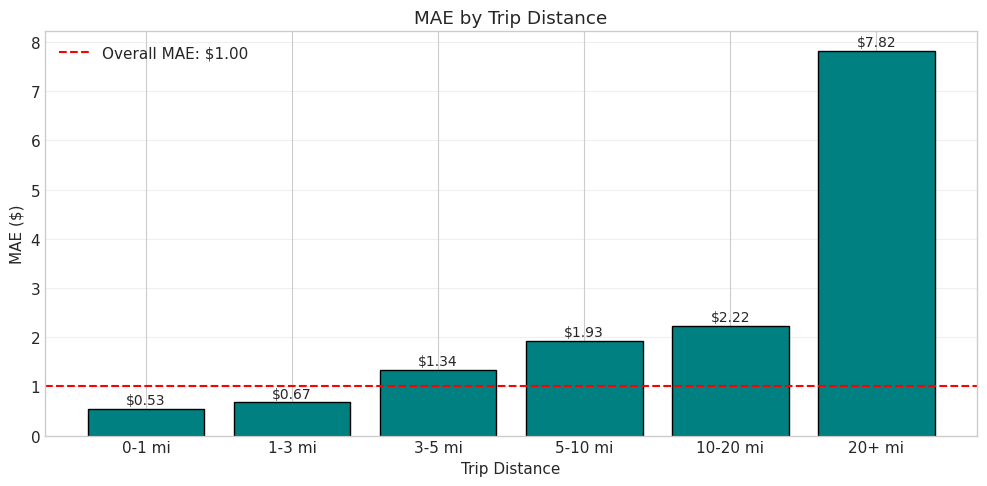

✅ Saved: ../reports/performance_by_distance.png


In [17]:
# Performance by trip distance
if 'trip_distance' in test_df_analysis.columns:
    distance_bins = [0, 1, 3, 5, 10, 20, float('inf')]
    distance_labels = ['0-1 mi', '1-3 mi', '3-5 mi', '5-10 mi', '10-20 mi', '20+ mi']
    
    test_df_analysis['distance_range'] = pd.cut(
        test_df_analysis['trip_distance'], 
        bins=distance_bins, 
        labels=distance_labels,
        include_lowest=True
    )
    
    distance_metrics = test_df_analysis.groupby('distance_range', observed=True).apply(
        lambda x: pd.Series({
            'MAE': mean_absolute_error(x[TARGET], x['predicted']),
            'Count': len(x),
            'Pct': len(x) / len(test_df_analysis) * 100
        })
    ).reset_index()
    
    fig, ax = plt.subplots(figsize=(10, 5))
    bars = ax.bar(distance_metrics['distance_range'].astype(str), distance_metrics['MAE'], 
                  color='teal', edgecolor='black')
    ax.axhline(y=test_metrics['MAE'], color='red', linestyle='--', label=f'Overall MAE: ${test_metrics["MAE"]:.2f}')
    ax.set_xlabel('Trip Distance')
    ax.set_ylabel('MAE ($)')
    ax.set_title('MAE by Trip Distance')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    for bar, val in zip(bars, distance_metrics['MAE']):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
               f'${val:.2f}', ha='center', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(REPORTS_DIR / 'performance_by_distance.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Saved: {REPORTS_DIR / 'performance_by_distance.png'}")


## 7. Worst Predictions Analysis

In [18]:
# Analyze worst predictions
worst_predictions = test_df_analysis.nlargest(100, 'abs_error')

print("📊 Top 10 Worst Predictions:")
print("="*80)
display_cols = [TARGET, 'predicted', 'error', 'abs_error']
if 'trip_distance' in worst_predictions.columns:
    display_cols.insert(0, 'trip_distance')
if 'pickup_hour' in worst_predictions.columns:
    display_cols.insert(0, 'pickup_hour')

worst_predictions[display_cols].head(10)


📊 Top 10 Worst Predictions:


,pickup_hour,trip_distance,fare_amount,predicted,error,abs_error
1598723,11,4.92,395.00,44.891770,350.108230,350.108230
1158799,1,0.13,350.00,8.210273,341.789727,341.789727
1066959,23,0.15,300.00,7.111569,292.888431,292.888431
914936,20,78.11,5.02,291.757202,-286.737202,286.737202
1583216,23,5.25,300.00,31.669472,268.330528,268.330528
2166204,20,18.94,350.00,91.188979,258.811021,258.811021
2078855,5,0.22,258.09,7.362229,250.727771,250.727771
609189,10,2.49,250.00,14.488711,235.511289,235.511289
1202675,16,0.55,240.00,8.056525,231.943475,231.943475
357501,9,20.91,348.50,117.838487,230.661513,230.661513


In [19]:
# Characteristics of worst predictions
print("\n📊 Characteristics of Worst 100 Predictions:")
print("-"*50)

# Compare with overall test set
comparison = pd.DataFrame({
    'Metric': ['Avg Actual Fare', 'Avg Predicted', 'Avg Abs Error'],
    'Worst 100': [
        f"${worst_predictions[TARGET].mean():.2f}",
        f"${worst_predictions['predicted'].mean():.2f}",
        f"${worst_predictions['abs_error'].mean():.2f}"
    ],
    'Overall Test': [
        f"${test_df_analysis[TARGET].mean():.2f}",
        f"${test_df_analysis['predicted'].mean():.2f}",
        f"${test_df_analysis['abs_error'].mean():.2f}"
    ]
})

print(comparison.to_string(index=False))

# Check if worst predictions are for high fare trips
if 'fare_range' in worst_predictions.columns:
    print("\n📊 Worst Predictions by Fare Range:")
    print(worst_predictions['fare_range'].value_counts())



📊 Characteristics of Worst 100 Predictions:
--------------------------------------------------
         Metric Worst 100 Overall Test
Avg Actual Fare   $245.92       $19.22
  Avg Predicted   $147.70       $19.21
  Avg Abs Error   $145.63        $1.00

📊 Worst Predictions by Fare Range:
fare_range
$100+      95
$50-100     4
$0-10       1
$10-20      0
$20-30      0
$30-50      0
Name: count, dtype: int64


## 8. Model Interpretation

In [20]:
# Feature correlation with error
numeric_features = test_df_analysis[ALL_FEATURES].select_dtypes(include=[np.number]).columns.tolist()

# Calculate correlation between features and absolute error
error_correlations = []
for feat in numeric_features:
    corr = test_df_analysis[feat].corr(test_df_analysis['abs_error'])
    error_correlations.append({'feature': feat, 'correlation': corr})

error_corr_df = pd.DataFrame(error_correlations).sort_values('correlation', key=abs, ascending=False)

print("📊 Features Most Correlated with Prediction Error:")
print(error_corr_df.head(15).to_string(index=False))


📊 Features Most Correlated with Prediction Error:
              feature  correlation
        trip_distance     0.277253
trip_duration_minutes     0.259398
        avg_speed_mph     0.164937
            has_tolls     0.133512
         PULocationID    -0.048932
         pickup_month     0.043685
             VendorID    -0.041452
      passenger_count    -0.027028
             hour_sin     0.023786
          pickup_hour    -0.018674
         DOLocationID    -0.017442
             hour_cos     0.014401
     pickup_dayofweek     0.008584
           is_weekend     0.005733
              dow_cos    -0.001454


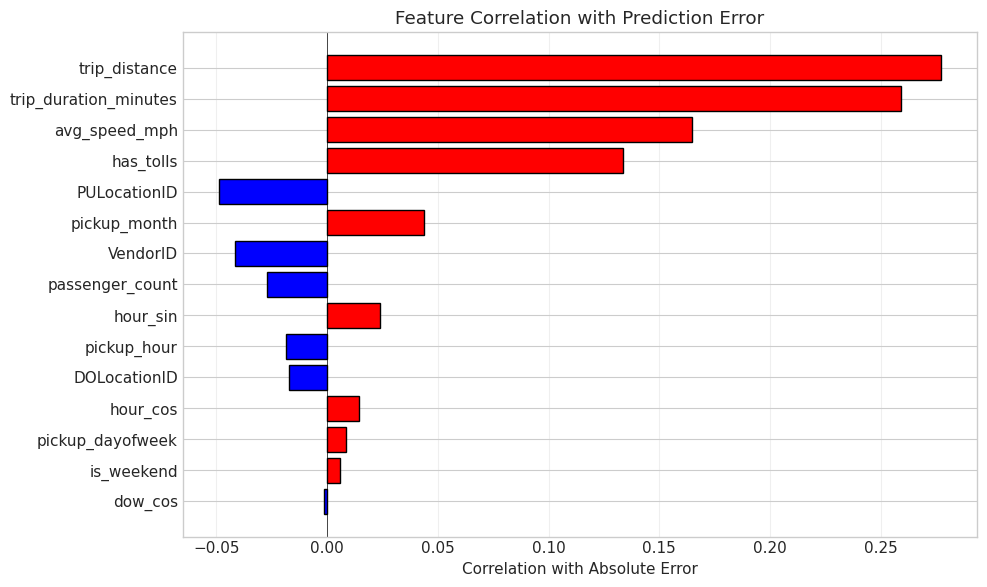

✅ Saved: ../reports/error_correlation.png


In [21]:
# Visualize error correlation
top_corr = error_corr_df.head(15)

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['red' if x > 0 else 'blue' for x in top_corr['correlation']]
bars = ax.barh(range(len(top_corr)), top_corr['correlation'].values, color=colors, edgecolor='black')
ax.set_yticks(range(len(top_corr)))
ax.set_yticklabels(top_corr['feature'].values)
ax.invert_yaxis()
ax.axvline(x=0, color='black', linewidth=0.5)
ax.set_xlabel('Correlation with Absolute Error')
ax.set_title('Feature Correlation with Prediction Error')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(REPORTS_DIR / 'error_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Saved: {REPORTS_DIR / 'error_correlation.png'}")


## 9. Save Evaluation Results

In [22]:
# Compile evaluation results
evaluation_results = {
    'model_name': MODEL_NAME,
    'model_type': model_metadata['model_type'],
    'evaluation_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'metrics': {
        'train': train_metrics,
        'validation': val_metrics,
        'test': test_metrics
    },
    'error_percentiles': dict(zip(
        [f'p{p}' for p in percentiles],
        abs_error_percentiles.tolist()
    )),
    'feature_importance': feature_importance.to_dict() if feature_importance is not None else None,
    'error_correlations': error_corr_df.head(20).to_dict()
}

# Save results
eval_path = MODELS_DIR / 'evaluation_results.joblib'
joblib.dump(evaluation_results, eval_path)
print(f"✅ Saved evaluation results: {eval_path}")


✅ Saved evaluation results: ../models/evaluation_results.joblib


## 10. Summary & Recommendations

In [23]:
print("="*70)
print("              📋 MODEL EVALUATION SUMMARY")
print("="*70)

print(f"""
MODEL INFORMATION:
   Name: {MODEL_NAME}
   Type: {model_metadata['model_type']}
   Features: {len(ALL_FEATURES)}

PERFORMANCE METRICS (Test Set):
   MAE:  ${test_metrics['MAE']:.4f}
   RMSE: ${test_metrics['RMSE']:.4f}
   R²:   {test_metrics['R²']:.4f}
   MAPE: {test_metrics['MAPE']:.2f}%

ERROR DISTRIBUTION:
   50th percentile (Median): ${abs_error_percentiles[0]:.2f}
   90th percentile:          ${abs_error_percentiles[2]:.2f}
   95th percentile:          ${abs_error_percentiles[3]:.2f}
""")

# Identify model strengths and weaknesses
print("STRENGTHS:")
if test_metrics['R²'] > 0.8:
    print(f"   ✅ Good R² score ({test_metrics['R²']:.4f}) - explains variance well")
if test_metrics['MAPE'] < 20:
    print(f"   ✅ Low MAPE ({test_metrics['MAPE']:.2f}%) - consistent percentage error")
if abs(train_metrics['MAE'] - test_metrics['MAE']) < 0.5:
    print(f"   ✅ Low overfitting (Train-Test MAE gap: ${abs(train_metrics['MAE'] - test_metrics['MAE']):.2f})")

print("\nAREAS FOR IMPROVEMENT:")
if test_metrics['MAE'] > 2.5:
    print(f"   ⚠️ MAE could be lower (current: ${test_metrics['MAE']:.2f})")
# Check if high fare predictions are worse
high_fare_mae = fare_range_metrics[fare_range_metrics['fare_range'].astype(str).str.contains('50|100')]['MAE'].mean()
if high_fare_mae > test_metrics['MAE'] * 1.5:
    print(f"   ⚠️ High fare predictions need improvement (MAE: ${high_fare_mae:.2f})")

print(f"""
RECOMMENDATIONS:
   1. Model is ready for production deployment
   2. Monitor performance on high-fare trips (> $50)
   3. Consider adding more features for long-distance trips
   4. Set up alerting for MAE > ${test_metrics['MAE'] * 1.2:.2f}

SAVED REPORTS:
   📁 {REPORTS_DIR}/
      - metrics_comparison.png
      - error_analysis.png
      - feature_importance.png
      - performance_by_hour.png
      - performance_by_day.png
      - performance_by_fare_range.png
      - performance_by_distance.png
      - error_correlation.png
""")

print("="*70)
print("✅ Model Evaluation Complete!")
print("   Next: 06_monitoring.ipynb (Drift Detection)")
print("="*70)


              📋 MODEL EVALUATION SUMMARY

MODEL INFORMATION:
   Name: random_forest
   Type: tuned
   Features: 18

PERFORMANCE METRICS (Test Set):
   MAE:  $1.0026
   RMSE: $3.2155
   R²:   0.9643
   MAPE: 5.57%

ERROR DISTRIBUTION:
   50th percentile (Median): $0.39
   90th percentile:          $1.83
   95th percentile:          $3.46

STRENGTHS:
   ✅ Good R² score (0.9643) - explains variance well
   ✅ Low MAPE (5.57%) - consistent percentage error
   ✅ Low overfitting (Train-Test MAE gap: $0.02)

AREAS FOR IMPROVEMENT:
   ⚠️ High fare predictions need improvement (MAE: $8.89)

RECOMMENDATIONS:
   1. Model is ready for production deployment
   2. Monitor performance on high-fare trips (> $50)
   3. Consider adding more features for long-distance trips
   4. Set up alerting for MAE > $1.20

SAVED REPORTS:
   📁 ../reports/
      - metrics_comparison.png
      - error_analysis.png
      - feature_importance.png
      - performance_by_hour.png
      - performance_by_day.png
      - perf

---

## 🔗 Next Steps

1. **06_monitoring.ipynb** - Setup drift detection with Evidently
2. **Deploy API** - Update FastAPI with tuned model
3. **Production Pipeline** - Create automated pipeline script